In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Imports Libraries and Tools**

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array

# **Load Datasets**

In [5]:
IMAGE_SIZE = 128
BATCH_SIZE = 20
EPOCHS = 10

train_dir = '/content/drive/MyDrive/MRI Images/Training/'
test_dir = '/content/drive/MyDrive/MRI Images/Testing/'
class_labels = sorted(os.listdir(train_dir))

# **Data Visualization**

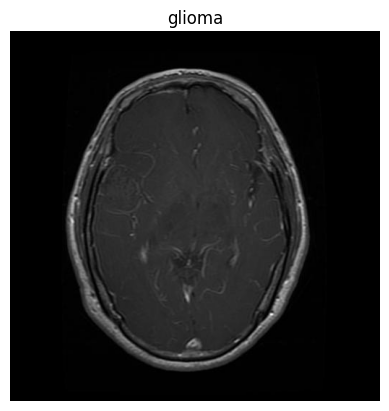

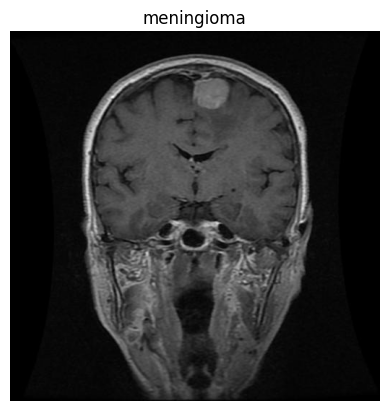

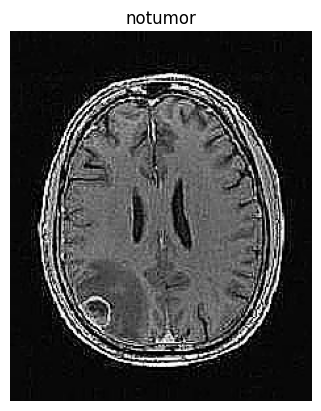

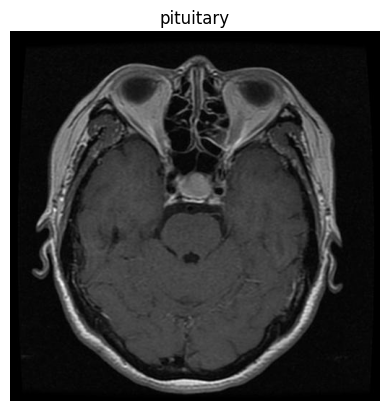

In [6]:
# Optional: Visualize one sample image from each class
for label in class_labels:
    sample_dir = os.path.join(train_dir, label)
    sample_image = os.listdir(sample_dir)[0]
    img = load_img(os.path.join(sample_dir, sample_image))
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    plt.show()

# **Image Preprocessing (Helper Functions)**

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1,
    class_mode='sparse',
    shuffle=False
)

Found 5143 images belonging to 4 classes.
Found 569 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# **MODEL:**                                                                    **WE ARE USING VGG16 FOR TRANSFER LEARNING.**                                     

The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

In [8]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# **Train and Val Plots**

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3039s 12s/step - loss: 0.7612 - sparse_categorical_accuracy: 0.6718 - val_loss: 0.5918 - val_sparse_categorical_accuracy: 0.7838
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 51s 199ms/step - loss: 0.2965 - sparse_categorical_accuracy: 0.8807 - val_loss: 0.4937 - val_sparse_categorical_accuracy: 0.8330
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 51s 196ms/step - loss: 0.2423 - sparse_categorical_accuracy: 0.9132 - val_loss: 0.4492 - val_sparse_categorical_accuracy: 0.8225
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 50s 194ms/step - loss: 0.2098 - sparse_categorical_accuracy: 0.9203 - val_loss: 0.4844 - val_sparse_categorical_accuracy: 0.8330
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 50s 194ms/step - loss: 0.1291 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.4375 - val_sparse_categorical_accuracy: 0.8682
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 51s 198ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9578 - val_loss: 0.4502 - val_sparse_categorical_acc

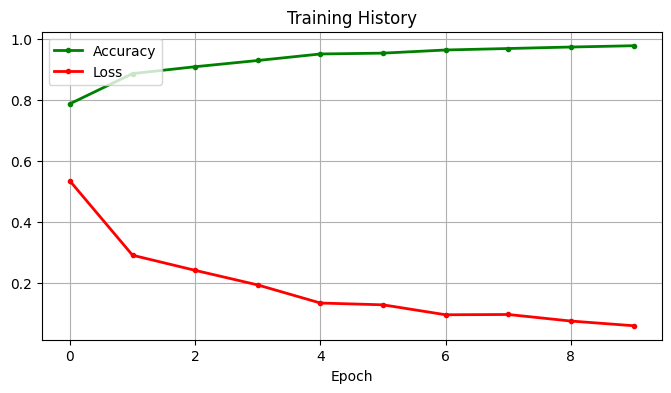

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Training History')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

# **Model Classification Report**

In [11]:
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 888s 676ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.90      0.92       300
  meningioma       0.97      0.78      0.86       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.84      0.99      0.91       300

    accuracy                           0.92      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.92      0.92      1311



# **Model Confusion Plot**

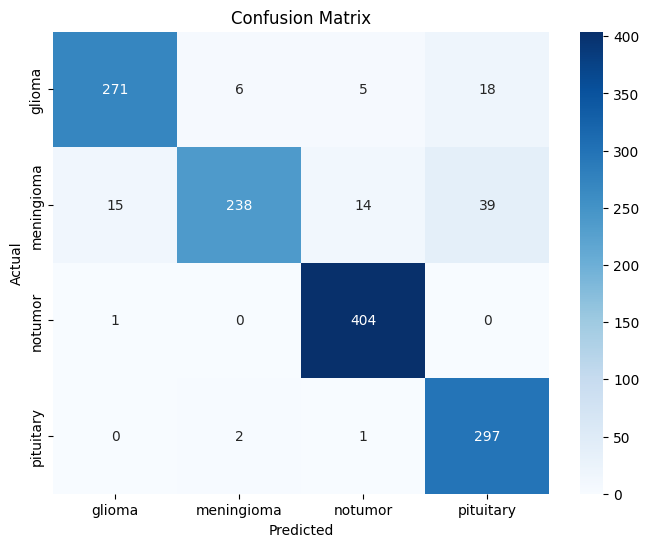

In [12]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Roc Curve Plot**

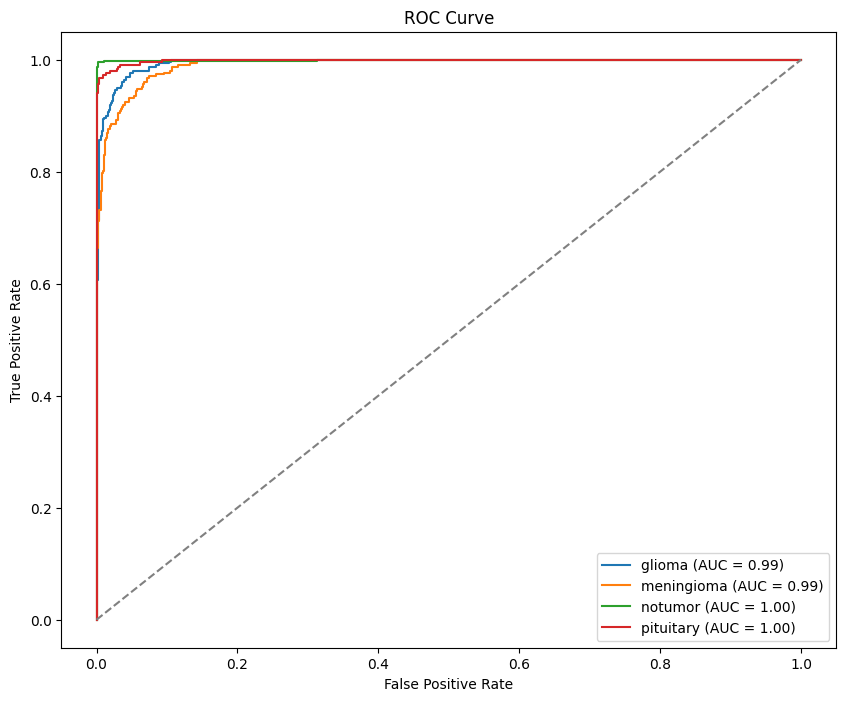

In [13]:
true_labels_bin = label_binarize(true_labels, classes=np.arange(len(class_labels)))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# **Save & Load Model**

In [14]:
model.save('model.h5')


In [15]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

# **MRI Tumor Detection System**

In [16]:
def detect_and_display(img_path, model, image_size=128):
    try:
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)
        pred_class = np.argmax(predictions, axis=1)[0]
        confidence = np.max(predictions)

        label = class_labels[pred_class]
        result = "No Tumor" if label == 'notumor' else f"Tumor: {label}"

        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence * 100:.2f}%)")
        plt.show()
    except Exception as e:
        print("Error:", str(e))

# Example usage:
# model = load_model('model.h5')
# detect_and_display('/content/drive/MyDrive/sample_test_image.jpg', model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


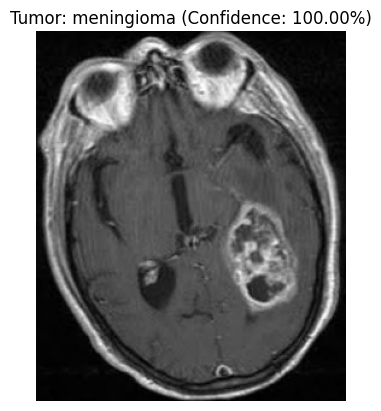

In [17]:
# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


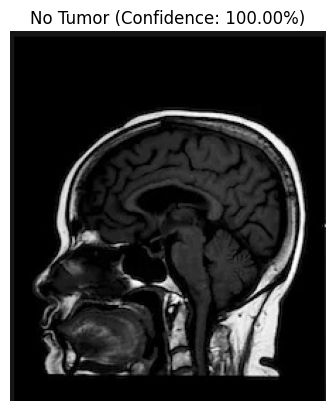

In [18]:
# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


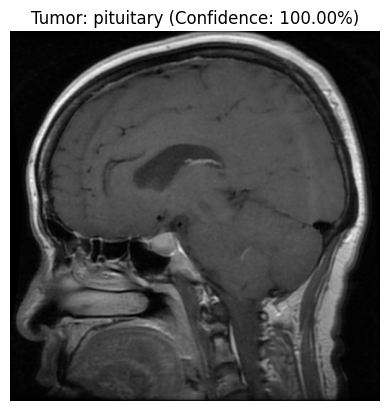

In [19]:
# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-piTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


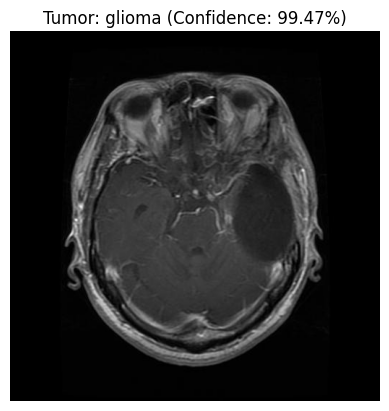

In [20]:
# Example usage
image_path = '/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)